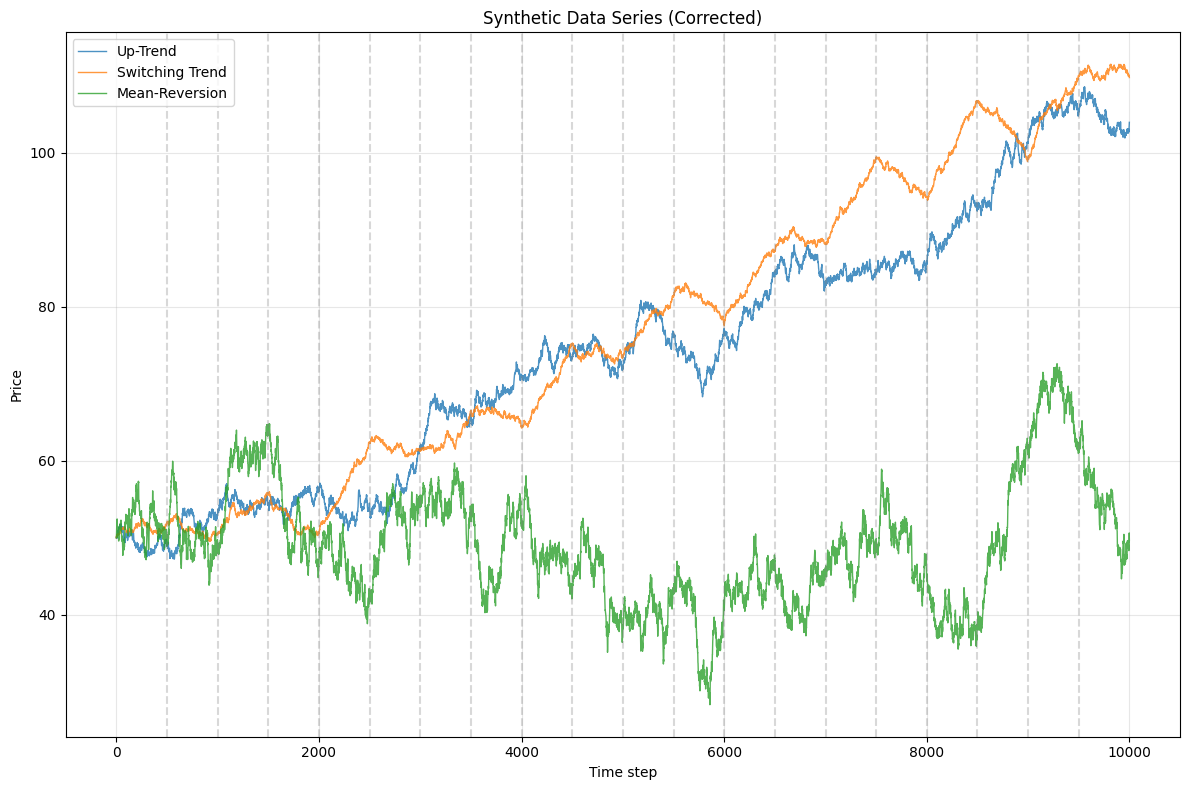

Trend series range: 47.22 to 108.58
Switching series range: 49.56 to 111.50
Mean-reversion series range: 28.31 to 72.61


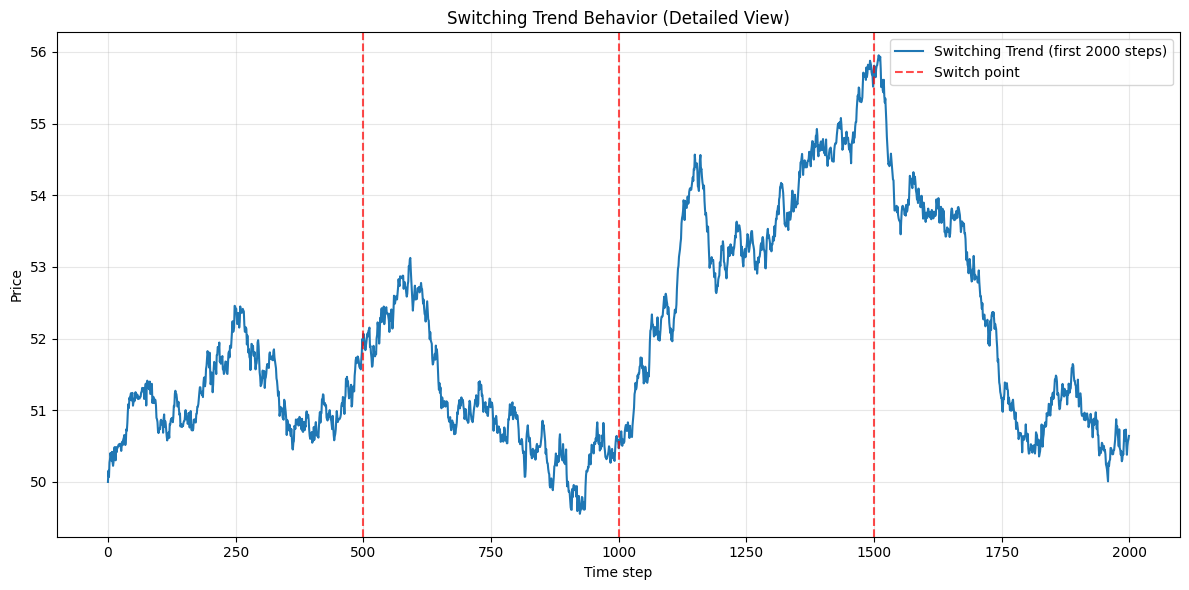

In [176]:
import torch
import matplotlib.pyplot as plt
from typing import Optional

def simulate_ou_switching(
    mu_series: torch.Tensor,
    theta_pos: float,
    theta_neg: float,
    sigma: float,
    dt: float,
    switch_interval: int = 500
) -> torch.Tensor:
    """
    Simulate an Ornstein–Uhlenbeck process with alternating drift signs.
    
    Args:
        mu_series (torch.Tensor): 1-D tensor of length T representing μₜ at each step
        theta_pos (float): theta for positive trend periods
        theta_neg (float): theta for negative trend periods  
        sigma (float): diffusion coefficient (volatility)
        dt (float): time increment size
        switch_interval (int): number of steps between switching drift sign
    
    Returns:
        torch.Tensor: simulated OU path of length T
    """
    dt_tensor = torch.tensor(dt)
    sqrt_dt = torch.sqrt(dt_tensor)
    
    T = mu_series.shape[0]
    P = torch.zeros(T)
    P[0] = mu_series[0]
    
    for t in range(1, T):
        # Determine which regime we're in
        regime = (t // switch_interval) % 2
        
        if regime == 0:  # Positive trend regime
            theta = theta_pos
            drift_sign = 1.0
        else:  # Negative trend regime  
            theta = theta_neg
            drift_sign = -1.0
        
        # Mean-reversion drift with alternating sign
        drift = drift_sign * theta * (mu_series[t] - P[t - 1]) * dt
        
        # Brownian diffusion term
        diffusion = sigma * sqrt_dt * torch.randn(())
        
        P[t] = P[t - 1] + drift + diffusion
    
    return P

def simulate_ou_standard(
    mu_series: torch.Tensor,
    theta: float,
    sigma: float,
    dt: float
) -> torch.Tensor:
    """
    Standard OU simulation for comparison.
    """
    dt_tensor = torch.tensor(dt)
    sqrt_dt = torch.sqrt(dt_tensor)

    T = mu_series.shape[0]
    P = torch.zeros(T)
    P[0] = mu_series[0]

    for t in range(1, T):
        drift = theta * (mu_series[t] - P[t - 1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t - 1] + drift + diffusion

    return P

# Simulation parameters
T = 10000
dt = 1.0 / T

# Create mean series
mu_trend = torch.linspace(50, 50 + 0.01 * T, T)  # Trending mean
mu_flat = torch.full((T,), 50.0)  # Constant mean
mu_switch = torch.linspace(50, 50 + 0.01 * T, T)  # Trending mean for switching

# Simulate the processes
torch.manual_seed(42)  # For reproducibility

# Up-trending series
P_trend = simulate_ou_standard(mu_trend, theta=2.0, sigma=20.0, dt=dt)

# Mean-reverting series  
P_flat = simulate_ou_standard(mu_flat, theta=20.0, sigma=50.0, dt=dt)

# Switching trend series (corrected)
P_switch = simulate_ou_switching(
    mu_switch, 
    theta_pos=7.5, 
    theta_neg=2.5, 
    sigma=10.0, 
    dt=dt,
    switch_interval=500
)

# Plot results
plt.figure(figsize=(12, 8))

plt.plot(P_trend, label="Up-Trend", linewidth=1.0, alpha=0.8)
plt.plot(P_switch, label="Switching Trend", linewidth=1.0, alpha=0.8)
plt.plot(P_flat, label="Mean-Reversion", linewidth=1.0, alpha=0.8)

# Add vertical lines to show switching points
for i in range(1, T // 500):
    plt.axvline(x=i * 500, color='gray', linestyle='--', alpha=0.3)

plt.margins(x=0.05, y=0.05)
plt.xlabel("Time step")
plt.ylabel("Price")
plt.title("Synthetic Data Series (Corrected)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some diagnostics
print(f"Trend series range: {P_trend.min():.2f} to {P_trend.max():.2f}")
print(f"Switching series range: {P_switch.min():.2f} to {P_switch.max():.2f}")
print(f"Mean-reversion series range: {P_flat.min():.2f} to {P_flat.max():.2f}")

# Show the switching behavior more clearly
plt.figure(figsize=(12, 6))
plt.plot(P_switch[:2000], label="Switching Trend (first 2000 steps)", linewidth=1.5)
plt.axvline(x=500, color='red', linestyle='--', alpha=0.7, label='Switch point')
plt.axvline(x=1000, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=1500, color='red', linestyle='--', alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Price")
plt.title("Switching Trend Behavior (Detailed View)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()